In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '7'

model_device = 0
paired_model_device = 0


import sys

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, AutoModel
# from peft import PeftConfig, PeftModel

import torch

import numpy as np
import pandas as pd
import re

from matplotlib import pyplot

from tqdm.auto import tqdm

In [2]:
OUTPUT_DIR = './generated/prompt/'

In [3]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# build model

In [4]:
# model_name = "weight/distilgpt2-long"
# model_name = 'weight/distilgpt2-extend'
# model_name = 'weight/distilgpt2-new'
# model_name = 'weight/distilgpt2-paired'
# model_name = "weight/bloom-560m-shuffle/"
model_name = 'GPT2-extend/checkpoint-25000/'
# model_name = 'BLOOM-extend/checkpoint-15000/'
# model_name = 'GPT2-new/checkpoint-35000/'
# model_name = 'GPT2-paired/checkpoint-5000/'

tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(model_name, local_files_only=True, torch_dtype=torch.bfloat16).to(model_device).eval()
# model = model.to_bettertransformer()

# Load the transformer model
prompt_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=model.device, batch_size=512)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [5]:
paired_tokenizer = tokenizer
paired_model = model
paired_prompt_pipe = prompt_pipe

In [6]:
# # model_name = 'GPT2-new/checkpoint-35000/'
# # model_name = 'GPT2-paired/checkpoint-15000/'
# model_name = 'weight/distilgpt2-new'

# paired_tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
# paired_model = AutoModelForCausalLM.from_pretrained(model_name, local_files_only=True, torch_dtype=torch.bfloat16).to(paired_model_device).eval()
# # paired_model = paired_model.to_bettertransformer()

# # paired_model = PeftModel.from_pretrained(paired_model, model_name)

# # Load the transformer model
# paired_prompt_pipe = pipeline("text-generation", model=paired_model, tokenizer=paired_tokenizer, device=paired_model.device, batch_size=256)

In [7]:
def process_input(base, length=None, condition=None):
    
    if type(base) == str:
        
        base =  [base]
        if length is None:
            length = [None]
        elif type(length) == str:
            length = [length]
        else:
            base = base * len(length)
        
    else:
        
        if length is None:
            length = [None] * len(base)
        elif type(length) == str:
            length = [length] * len(base)
        else:
            assert len(base) == len(length)
            
    if condition is None:
        return base, length

    if type(condition) == str:
        condition = [condition] * len(base)
    else:
        assert len(base) == len(condition)
        
    return base, length, condition
    

def get_inputs(input_type, bases, lengths, conditions=None):
    
    prompts = list()
    
    for i, (base, length) in enumerate(zip(bases, lengths)):
        
        if length is None:
            prompt = f'<{input_type} prompt>:{base}'.lower()
        else:
            prompt = f'<{length} {input_type} prompt>:{base}'.lower()
            
        if conditions is not None:
            condition = re.sub(';\s*$', '', conditions[i])
            prompt = f'{"{{"}{condition}{"}}"}{prompt}'
            
        prompt = f'<|endoftext|>{prompt}'
            
        prompts.append(prompt)
        
    return prompts
    

pattern_positive = re.compile(r'<[a-z\s]*positive prompt\>:\s*(.+)$')
pattern_negative = re.compile(r'<[a-z\s]*negative prompt\>:\s*(.+)$')
        
def get_outputs(input_type, outputs):
    
    prompts = list()
    
    for item in outputs:
        
        results = list()
        
        for i in item:
            
            if input_type == 'positive':
                
                result = pattern_positive.search(i['generated_text']).groups()[0]
                
            elif input_type == 'negative':
                
                result = pattern_negative.search(i['generated_text']).groups()[0]
                
            results.append(result)
        
        prompts.append(results)
    
    return prompts

def extend(input_type, base='', length=None, do_sample=True, num_beams=1, top_k=50, max_length=100, num_return_sequences=1, return_dict=False):
    
    bases, lengths = process_input(base=base, length=length)
    
    inputs = get_inputs(input_type, bases, lengths)

#     if len(inputs) > 1:
#         inputs = InferenceDataset(inputs)

    with torch.no_grad():
        # with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
            outputs = prompt_pipe(
                inputs, 
                do_sample=do_sample, num_beams=num_beams, num_return_sequences=num_return_sequences, top_k=top_k, 
                max_length=max_length, #min_new_tokens=15,
                # early_stopping=True, use_cache=True,
                # suppress_tokens=[tokenizer.vocab['{{'], tokenizer.vocab['}}'], tokenizer.vocab['positive'], tokenizer.vocab['<']]
            )

    prompts = get_outputs(input_type, outputs)
    
    if not return_dict:
        return prompts
    
    return [{
        f'{input_type}_base': base, 
        f'{input_type}_length': length, 
        f'{input_type}_prompts': prompt
    } for base, length, prompt in zip(bases, lengths, prompts)]

def paired_extend(input_type, base='', condition='', length=None, do_sample=True, num_beams=1, top_k=50, max_length=200, num_return_sequences=1, return_dict=False):
    
    bases, lengths, conditions = process_input(base=base, length=length, condition=condition)
    
    inputs = get_inputs(input_type, bases, lengths, conditions)

#     if len(inputs) > 1:
#         inputs = InferenceDataset(inputs)
        
    with torch.no_grad():
        # with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
            outputs = paired_prompt_pipe(
                inputs, 
                do_sample=do_sample, num_beams=num_beams, num_return_sequences=num_return_sequences, top_k=top_k, 
                max_length=max_length, #min_new_tokens=15, #min_new_tokens=15,
                # early_stopping=True, use_cache=True,
                # suppress_tokens=[tokenizer.vocab['{{'], tokenizer.vocab['}}'], tokenizer.vocab['positive'], tokenizer.vocab['<']]
            )

    prompts = get_outputs(input_type, outputs)
    
    if not return_dict:
        return prompts
    
    return [{
        f'{input_type}_base': base, 
        f'{input_type}_length': length, 
        f'condition': condition, 
        f'{input_type}_prompts': prompt
    } for base, condition, length, prompt in zip(bases, conditions, lengths, prompts)]

# demo

In [8]:
positive_length = None
positive_base = "nsfw,"
negative_length = None
negative_base = ""

In [13]:
extended = extend('positive', [positive_base], positive_length, num_beams=1, do_sample=True, num_return_sequences=4)
extended

[['nsfw, masterpiece, best quality, 1girl, solo, standing split leg up, huge breasts, short hair;',
  'nsfw, masterpiece top quality, best quality, extreme detailed illustration, highest detailed ultra-detailed, 8k wallpaper;',
  'nsfw, best quality, masterpiece, highres, solo, simple background, standing, nude, completely nude;',
  'nsfw, highres, best quality, masterpiece, 1girl, solo, looking at viewer, simple background;']]

In [11]:
extended = extend('negative', [negative_base], negative_length, num_beams=1, do_sample=True, num_return_sequences=4)
extended

[['worst quality, low quality, greyscale, monochrome, comic, sketch, blurry;',
  'extra limbs, missing legs, poorly drawn feet, ugly, cross-eye, bad art, bad hands, deformed, blurry, bad anatomy, extra limbs, cloned face,asian, chinese;',
  'worst quality, low quality, blurry, deformed fingers, long fingers, interlocked fingers, watermark;',
  'bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality;']]

In [10]:
positive_base = extended[0][2]

In [ ]:
extended = paired_extend('negative', negative_base, positive_base, negative_length, num_beams=1, do_sample=True, num_return_sequences=4)
extended

# generate batch

## from empty

In [23]:
num_batch = 128
num_return_sequences = 128

positive_base = ''

results = list()

# for positive_length in ['short', 'medium', 'long', 'full', None]:
for positive_length in [None]:
    for _ in tqdm(range(num_batch)):
        extended = extend('positive', positive_base, positive_length, num_beams=1, do_sample=True, num_return_sequences=num_return_sequences)
        results.extend([(i,) for i in extended[0]])

positive_prompts = zip(* results)

  0%|          | 0/128 [00:00<?, ?it/s]

In [24]:
num_return_sequences = 2

batch_size = 48

negative_base = ''

negative_bases = [negative_base] * len(positive_prompts)


results = list()

for i in tqdm(range(0, len(positive_prompts), batch_size), leave=False):
    
    conditions_i = positive_prompts[i:i+batch_size]
    
    extended = paired_extend(
        'negative', 
        negative_bases[i:i+batch_size], conditions_i, None, 
        num_beams=1, do_sample=True, num_return_sequences=num_return_sequences, return_dict=True
    )
    for result in extended:
        results.extend([(result['condition'], i) for i in result['negative_prompts']])
        
positive_prompts, negative_prompts = zip(* results)

  0%|          | 0/342 [00:00<?, ?it/s]

In [32]:
num_return_sequences = 1

batch_size = 64

results = list()

for i in tqdm(range(0, len(positive_prompts), batch_size), leave=False):
    
#     extended = paired_extend(
#         'positive', 
#         positive_prompts[i:i+batch_size], negative_prompts[i:i+batch_size], None, 
#         num_beams=1, do_sample=True, num_return_sequences=num_return_sequences, return_dict=True
#     )
#     for result in extended:
#         results.extend([(i, result['condition']) for i in result['positive_prompts']])
    
    extended = paired_extend(
        'negative', 
        negative_prompts[i:i+batch_size], positive_prompts[i:i+batch_size], None, 
        num_beams=1, do_sample=True, num_return_sequences=num_return_sequences, return_dict=True
    )
    for result in extended:
        results.extend([(result['condition'], i) for i in result['negative_prompts']])

  0%|          | 0/512 [00:00<?, ?it/s]

/sunjie/kk-digital/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [33]:
df = pd.DataFrame(results, columns=['positive_prompt', 'negative_prompt'])
# df[['positive_base', 'negative_base']] = None

df.drop_duplicates(['positive_prompt', 'negative_prompt'], inplace=True)

# df.to_csv(os.path.join(OUTPUT_DIR, 'empty.tsv'), sep='\t', index=False)

df

,positive_prompt,negative_prompt
0,"a candybar made out of rubber in a zen garden,...",ng_deepnagetive_v1_75t;bodybuilder bad-hands-5...
1,"a candybar made out of rubber in a zen garden,...",ng_deepnagetive_v1_75t;bersecar;
2,"a logo of a smiling cartoon tiger, vector;",neg no text realistic photo details;okeh defoc...
3,"a logo of a smiling cartoon tiger, vector;",coffee beans;professional t-shirt design graphic;
4,"the most beautiful woman in the world, profess...",ng_deepnagetive_v1_75t;weirdcore worst quality...
...,...,...
32763,a bag of marbles sitting on top of a camera in...,"structurezoov21;body out of frame, broken limb..."
32764,"realistic, photorealism 3d model of a baby on ...",neg_facelift768;structurezoov21 structurezoov2...
32765,"realistic, photorealism 3d model of a baby on ...","bad-picture-chill-, bad_pictures;body out of f..."
32766,the first picture of the world's largest tree ...,"onsenaken;ahnk, surrealist nft style a man sta..."


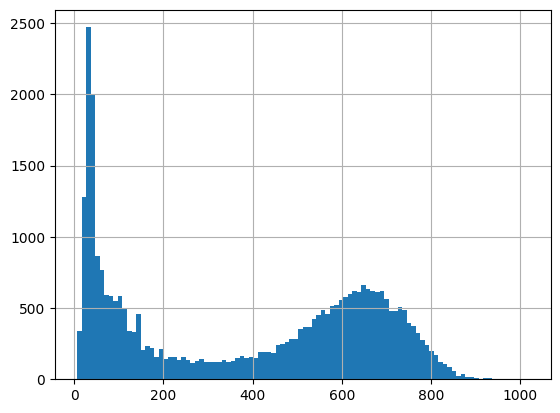

In [34]:
_ = df['negative_prompt'].str.len().hist(bins=100)

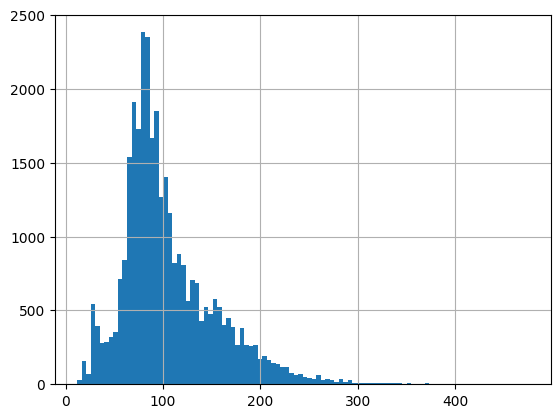

In [35]:
_ = df['positive_prompt'].str.len().hist(bins=100)

## from high score positive base

In [10]:
positive_freq_path = './data/environmental/positive_freqs.csv'

df = pd.read_csv(positive_freq_path)

positive_tags = df.query('num_select > 50 and num_unselect > 50 and p_value < 5e-2').sort_values('odds_ratio').tail(100)['tag']

negative_freq_path = './data/environmental/negative_freqs.csv'

df = pd.read_csv(negative_freq_path)

negative_tags = df.query('num_select > 50 and num_unselect > 50 and p_value < 5e-2').sort_values('odds_ratio').tail(100)['tag']

In [11]:
num_return_sequences = 32

batch_size = 16

positive_bases = list(positive_tags)

results = list()

for positive_length in tqdm(['short', 'medium', 'long', 'full', None], leave=False):

    for i in range(0, len(positive_bases), batch_size):

        positive_bases_i = positive_bases[i:i+batch_size]
        positive_bases_i = [f'{i},' for i in positive_bases_i]
        
        extended = extend(
            'positive', 
            positive_bases_i, positive_length, 
            num_beams=1, do_sample=True, num_return_sequences=num_return_sequences, return_dict=True
        )

        for result in extended:
            results.extend([(result['positive_base'], positive_length, i) for i in result['positive_prompts']])

_, positive_lengths, positive_prompts = zip(*results)

step1 = pd.DataFrame(results, columns=['positive_base', 'positive_length', 'positive_prompt'])

  0%|          | 0/5 [00:00<?, ?it/s]

/sunjie/kk-digital/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [12]:
num_return_sequences = 5

batch_size = 48

negative_lengths = positive_lengths

negative_bases = np.random.choice(negative_tags, len(positive_prompts), True)
negative_bases = [f'{i},' for i in negative_bases]


results = list()

for i in tqdm(range(0, len(positive_prompts), batch_size), leave=False):
    
    extended = paired_extend(
        'negative', 
        negative_bases[i:i+batch_size], positive_prompts[i:i+batch_size], negative_lengths[i:i+batch_size], 
        num_beams=1, do_sample=True, num_return_sequences=num_return_sequences, return_dict=True
    )
    
    for result in extended:
        results.extend([(result['negative_base'], result['negative_length'], result['condition'], i) for i in result['negative_prompts']])
        
step2 = pd.DataFrame(results, columns=['negative_base', 'negative_length', 'positive_prompt', 'negative_prompt'])

  0%|          | 0/334 [00:00<?, ?it/s]

In [13]:
df = pd.merge(step1, step2, on=['positive_prompt'], how='inner').drop_duplicates(['positive_prompt', 'negative_prompt'], keep='first')

df.to_csv(os.path.join(OUTPUT_DIR, 'pos2neg.tsv'), sep='\t', index=False)

df

,positive_base,positive_length,positive_prompt,negative_base,negative_length,negative_prompt
0,"romanticism,",short,"romanticism, long exposure photo of a dark blu...","low quality lowres black tongue,",short,"low quality lowres black tongue,weird image sp..."
1,"romanticism,",short,"romanticism, long exposure photo of a dark blu...","low quality lowres black tongue,",short,"low quality lowres black tongue,weird eyes 1.5..."
2,"romanticism,",short,"romanticism, long exposure photo of a dark blu...","low quality lowres black tongue,",short,"low quality lowres black tongue,weird eyes car..."
3,"romanticism,",short,"romanticism, long exposure photo of a dark blu...","low quality lowres black tongue,",short,"low quality lowres black tongue,weird eyes, ch..."
4,"romanticism,",short,"romanticism, long exposure photo of a dark blu...","low quality lowres black tongue,",short,"low quality lowres black tongue,weird looking ..."
...,...,...,...,...,...,...
96425,"2D environmental side scrolling,",None,"2d environmental side scrolling,website design...","low_quality,",None,"low_quality,talented green and blue colors tex..."
96426,"2D environmental side scrolling,",None,"2d environmental side scrolling,website design...","low_quality,",None,"low_quality,oscar-winning landing page with te..."
96427,"2D environmental side scrolling,",None,"2d environmental side scrolling,website design...","low_quality,",None,"low_quality,embeddingm4nts0n1-400xl monochrome..."
96428,"2D environmental side scrolling,",None,"2d environmental side scrolling,website design...","low_quality,",None,"low_quality,okra badhandsv5-neg by bad artist ..."


## from high score negative base

In [14]:
pos2neg = pd.read_csv(os.path.join(OUTPUT_DIR, 'pos2neg.tsv'), sep='\t')

positive_bases, negative_bases, positive_lengths = zip(*pos2neg[['positive_base', 'negative_base', 'positive_length']].drop_duplicates(keep='first').itertuples(index=False, name=None))

In [15]:
num_return_sequences = 2

batch_size = 24

results = list()

for i in tqdm(range(0, len(positive_bases), batch_size), leave=False):

    positive_bases_i = positive_bases[i:i+batch_size]
    
    negative_bases_i = negative_bases[i:i+batch_size]
    negative_bases_i = [re.sub(r',\s*$', ';', i) for i in negative_bases_i]
    
    positive_length_i = positive_lengths[i:i+batch_size]

    extended = paired_extend(
        'positive', 
        positive_bases_i, negative_bases_i, positive_length_i, 
        num_beams=1, do_sample=True, num_return_sequences=num_return_sequences, return_dict=True
    )

    for result in extended:
        results.extend([(result['positive_base'], result['positive_length'], re.sub(r'[,;\s]+$', ',', result['condition']), i) for i in result['positive_prompts']])

positive_bases, positive_lengths, negative_bases, positive_prompts = zip(*results)
            
step1 = pd.DataFrame(results, columns=['positive_base', 'positive_length', 'negative_base', 'positive_prompt'])

  0%|          | 0/569 [00:00<?, ?it/s]

/sunjie/kk-digital/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [16]:
num_return_sequences = 3

batch_size = 24

results = list()

for i in tqdm(range(0, len(positive_prompts), batch_size), leave=False):
    
    negative_bases_i = negative_bases[i:i+batch_size]
    negative_bases_i = [re.sub(r'[,;\s]+$', ',', i) for i in negative_bases_i]
    
    negative_length_i = positive_lengths[i:i+batch_size]
    
    extended = paired_extend(
        'negative', 
        negative_bases_i, positive_prompts[i:i+batch_size], negative_length_i, 
        num_beams=1, do_sample=True, num_return_sequences=num_return_sequences, return_dict=True, max_length=300
    )
    
    for result in extended:
        results.extend([(result['negative_base'], result['negative_length'], result['condition'], i) for i in result['negative_prompts']])
        
step2 = pd.DataFrame(results, columns=['negative_base', 'negative_length', 'positive_prompt', 'negative_prompt'])

  0%|          | 0/1138 [00:00<?, ?it/s]

In [17]:
df = pd.merge(step1, step2, on=['negative_base', 'positive_prompt'], how='inner').drop_duplicates(['positive_prompt', 'negative_prompt'], keep='first')

df.to_csv(os.path.join(OUTPUT_DIR, 'neg2pos.tsv'), sep='\t', index=False)

df

,positive_base,positive_length,negative_base,positive_prompt,negative_length,negative_prompt
0,"romanticism,",short,"low quality lowres black tongue,","romanticism,oscar winning hyperrealistic maste...",short,"low quality lowres black tongue, bad anatomy;"
1,"romanticism,",short,"low quality lowres black tongue,","romanticism,oscar winning hyperrealistic maste...",short,"low quality lowres black tongue, two heads 2gi..."
2,"romanticism,",short,"low quality lowres black tongue,","romanticism,oscar winning hyperrealistic maste...",short,"low quality lowres black tongue, overexposed;"
3,"romanticism,",short,"low quality lowres black tongue,","romanticism,whimsical and dreamy oil painting ...",short,"low quality lowres black tongue,x-ray photogra..."
4,"romanticism,",short,"low quality lowres black tongue,","romanticism,whimsical and dreamy oil painting ...",short,"low quality lowres black tongue,weird hands, e..."
...,...,...,...,...,...,...
81865,"2D environmental side scrolling,",NaN,"low_quality,","2d environmental side scrolling,whimsical colo...",NaN,"low_quality, worst qu ality;"
81866,"2D environmental side scrolling,",NaN,"low_quality,","2d environmental side scrolling,whimsical colo...",NaN,"low_quality, easynegativev2 ng_deepnegativexl ..."
81867,"2D environmental side scrolling,",NaN,"low_quality,","2d environmental side scrolling,whimsical wate...",NaN,"low_quality, lowres blurry image from back to ..."
81868,"2D environmental side scrolling,",NaN,"low_quality,","2d environmental side scrolling,whimsical wate...",NaN,"low_quality,photonous color scheme limited edi..."


In [ ]:
list(df.loc[df['negative_prompt'].str.contains('positive') + df['negative_prompt'].str.contains('prompt'), 'negative_prompt'])